In [2]:
import torch
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
import copy
import numpy as np
from models.fno import FNO
from models.pfno import PNO_Wrapper, PFNO
from models.laplace import LA_Wrapper
from models.mcdropout import generate_mcd_samples
from data.datasets import DarcyFlowDataset, KSDataset
import cmcrameri
from matplotlib.colors import Normalize
from torch.utils.data import DataLoader, random_split
import matplotlib as mpl
from matplotlib.colors import ListedColormap

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loader for best predictions

In [1]:
batch_size = 32
n_samples = 100 # Samples to create from predictive distributions
alpha = 0.05 # Parameter for confidence interval

In [3]:
data_dir = "../../data/KS/processed/"
train_data = KSDataset(data_dir, test = False, temporal_downscaling_factor=2, init_steps = 20, pred_horizon = 20)
train_data, val_data = random_split(train_data, lengths = [0.8,0.2], generator = torch.Generator().manual_seed(42))
test_data = KSDataset(data_dir, test = True, temporal_downscaling_factor=2, init_steps = 20, pred_horizon = 20)

# Get domain and range
x,y = test_data.get_coordinates(normalize = False)
y = y-y[0]
L = test_data.get_domain_range()

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

n_train = len(train_loader)
n_test = len(test_loader)

In [4]:
path = "../../results/ks_results/"

dropout_model = FNO(n_modes=(10,12), hidden_channels=20, in_channels = 3,dropout=0.05, lifting_channels = 128, projection_channels=128).to(device)

base_model_cp = torch.load(path+"dropout.pt", map_location=torch.device(device))
dropout_model.load_state_dict(base_model_cp)

laplace_cp = torch.load(path+"laplace.pt", map_location=torch.device(device))
laplace_model = copy.deepcopy(dropout_model)
laplace_model.load_state_dict(laplace_cp)
la_model = LA_Wrapper(laplace_model)
la_model.fit(val_loader)
la_model.optimize_precision()

# pfno_model = PFNO(n_modes=(10,12), hidden_channels=20, in_channels = 3,dropout=0.05, lifting_channels = 128, projection_channels=128).to(device)
# pfno_cp = torch.load(path+"sr_reparam.pt", map_location=torch.device(device))
# pfno_model.load_state_dict(pfno_cp)

pfno_model = PNO_Wrapper(copy.deepcopy(dropout_model)).to(device)
pfno_cp = torch.load(path+"sr_dropout.pt", map_location=torch.device(device))
pfno_model.load_state_dict(pfno_cp)

/tmp/ipykernel_533/1840766496.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_model_cp = torch.load(path+"dropout.pt", map_location=torch.device(device))
/tmp/ipyke

<All keys matched successfully>

# Predictions

In [9]:
np.random.seed(42)
samples = np.random.randint(0,n_test,10)

pfno_model.train()
dropout_model.train()
""" Prediction """
pred_pfno = []
pred_dropout = []
pred_la = []

with torch.no_grad():    
    index = 0
    for sample in samples:
        a,u = test_data.__getitem__(sample)
        a = a.to(device).unsqueeze(0)
        u = u.to(device).unsqueeze(0)
        dropout_pred = generate_mcd_samples(dropout_model, a, u.shape, n_samples=n_samples)
        pfno_pred = pfno_model(a, n_samples = n_samples)
        la_pred = la_model.predictive_samples(a)

        pred_dropout.append( dropout_pred )
        pred_pfno.append( pfno_pred )
        pred_la.append( la_pred )


pred_pfno = torch.cat(pred_pfno, dim = 0).cpu().numpy()
pred_dropout = torch.cat(pred_dropout, dim = 0).cpu().numpy()
pred_la = torch.cat(pred_la, dim = 0).cpu().numpy()

In [30]:
idx = 2

a,u = test_data.__getitem__(samples[idx])
a = a.unsqueeze(0).numpy()
u = u.unsqueeze(0).numpy()

preds = [pred_dropout[idx],pred_la[idx], pred_pfno[idx]]
names = ['MCDropout','Laplace approximation', 'PFNO']

In [35]:
def plot_statistics(truth, preds, names, grid, save_path = None, alpha = 0.05):
    n_models = len(preds)
    x,y = grid

    tick_size = 16
    title_size = 19
    mpl.rcParams['xtick.labelsize'] = tick_size
    mpl.rcParams['ytick.labelsize'] = tick_size

    # Discrete colorbar
    viridis = mpl.cm.get_cmap('viridis')    
    col_dict = {0: viridis(0),
                1: viridis(0.999)}

    # We create a colormar from our list of colors
    cmap_coverage = ListedColormap([col_dict[x] for x in col_dict.keys()])

    # Get scalings
    pred_array = np.array(preds)
    mse_norm = Normalize(vmin = 0, vmax = np.power(truth - pred_array.mean(axis = -1),2).max())
    std_norm = Normalize(vmin = 0, vmax = pred_array.std(axis = -1).max())
    

    fig, axs = plt.subplots(3,n_models, figsize = (18,9), #subplot_kw=dict(box_aspect=0.6),
                         sharex=True, sharey=True, layout = "constrained")
    for m, pred in enumerate(preds):
        truth = truth.squeeze()
        pred = pred.squeeze()
        # Calculate coverage
        q_lower = np.quantile(pred,alpha/2, axis = -1)
        q_upper = np.quantile(pred,1-alpha/2, axis = -1)
        coverage = (truth>q_lower) & (truth<q_upper)
        im1 = axs[0,m].pcolormesh(x,y,np.power(truth - pred.mean(axis = -1),2), shading = "nearest", cmap = "cmc.vik", norm = mse_norm, rasterized = True)
        im2 = axs[1,m].pcolormesh(x,y,pred.std(axis = -1), shading = "nearest", cmap = "cmc.lajolla", norm = std_norm, rasterized = True)
        im3 = axs[2,m].pcolormesh(x,y,coverage, shading = "nearest", cmap = cmap_coverage, rasterized = True)
        axs[0,m].set_title(names[m], fontsize = 24)
        print(f"{names[m]}- Coverage: {coverage.mean()}")
    cb1 = fig.colorbar(im1, ax = axs[0,m])
    cb1.ax.tick_params(labelsize=tick_size) 
    cb1.set_label('Squared error',size=title_size)
    cb2 = fig.colorbar(im2, ax = axs[1,m], label = "Standard deviation")
    cb2.ax.tick_params(labelsize=tick_size)
    cb2.set_label('Standard deviation',size=title_size)
    cb3 = fig.colorbar(im3, ax = axs[2,m], label = "", ticks = np.array([0,1]))
    cb3.ax.tick_params(labelsize=tick_size)
    cb3.set_label(r"Coverage ($\alpha = 0.05$)",size=title_size)

    # Set axis labels
    axs[0,0].set_ylabel("t", fontsize = tick_size)
    axs[1,0].set_ylabel("t", fontsize = tick_size)
    axs[2,0].set_ylabel("t", fontsize = tick_size)
    axs[2,0].set_xlabel("x", fontsize = tick_size)
    axs[2,1].set_xlabel("x", fontsize = tick_size)
    axs[2,2].set_xlabel("x", fontsize = tick_size)
    #fig.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi = 300, bbox_inches = "tight")
    
    plt.show()

/tmp/ipykernel_533/4075830827.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = mpl.cm.get_cmap('viridis')


MCDropout- Coverage: 0.308984375
Laplace approximation- Coverage: 0.0482421875
PFNO- Coverage: 0.8931640625


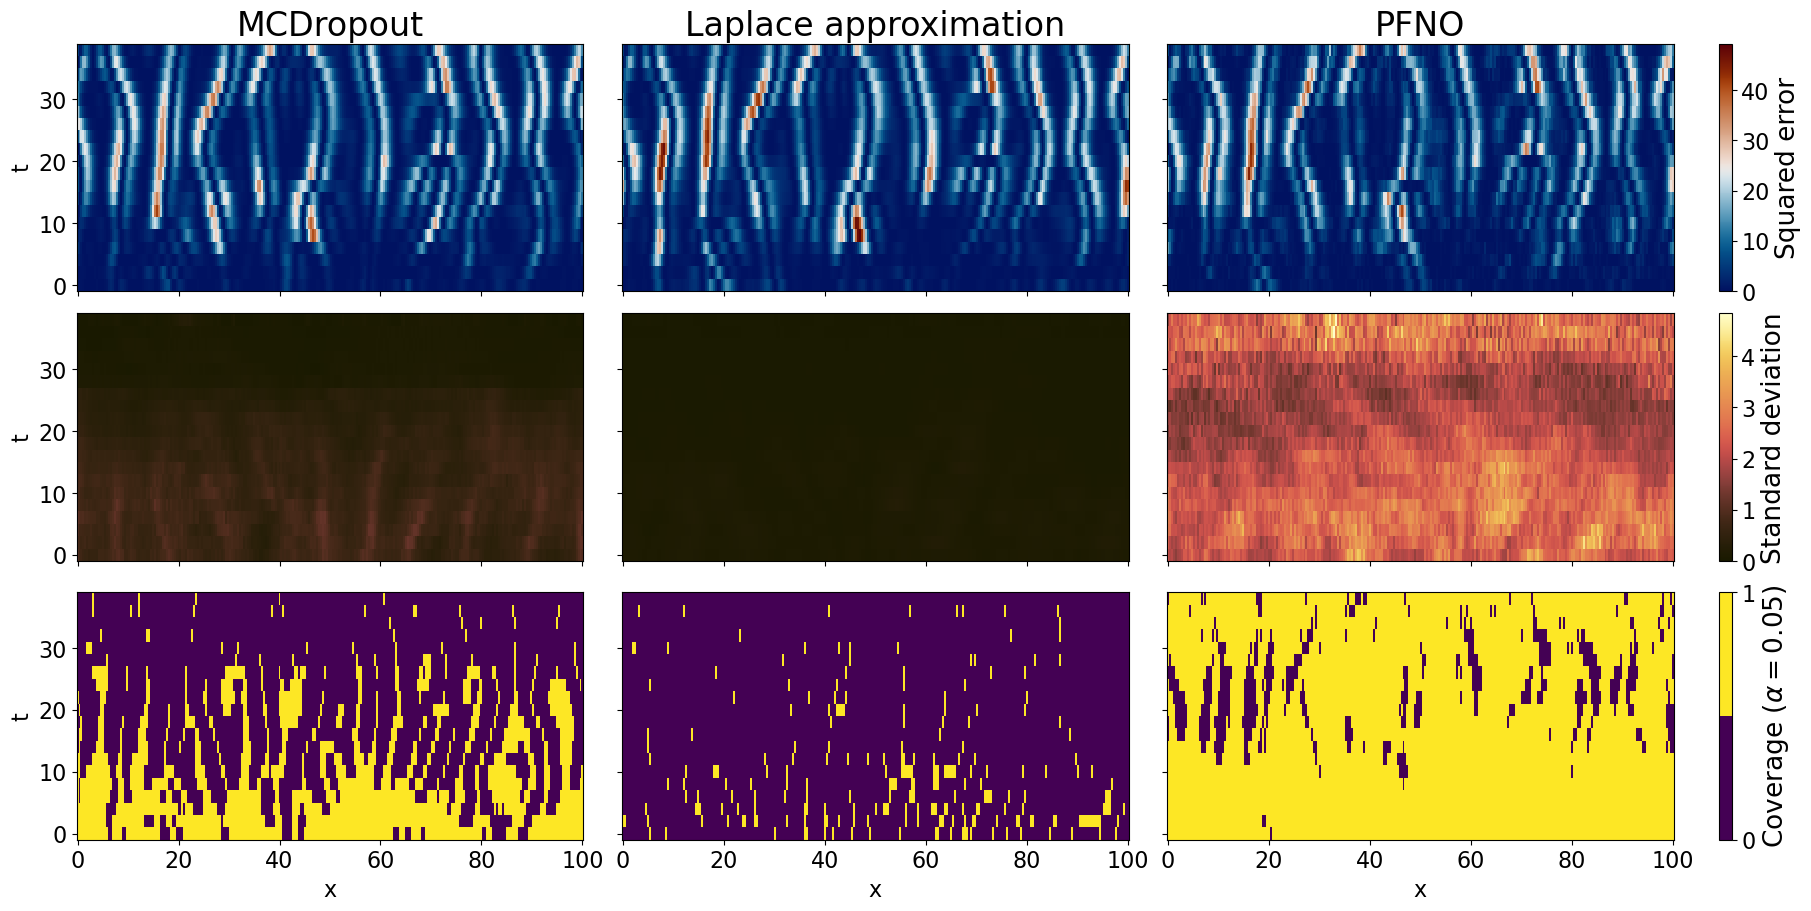

In [36]:
plot_statistics(u, preds, names, (x,y), save_path = "plots/ks_statistics.pdf")

In [9]:
def plot_predictions(truth, preds, names, grid, save_path = None, alpha = 0.05):
    n_models = len(preds)
    x,y = grid

    fig, axs = plt.subplots(4, n_models, figsize = (15, 10), subplot_kw=dict(box_aspect=0.6),
                         sharex=True, sharey=True)
    for m, pred in enumerate(preds):
            truth = truth.squeeze()
            pred = pred.squeeze()
            im1 = axs[0,m].pcolormesh(x,y,truth, shading = "nearest", cmap = "cmc.roma_r")
            im2 = axs[1,m].pcolormesh(x,y,pred.mean(axis = -1), shading = "nearest", cmap = "cmc.roma_r")
            im3 = axs[2,m].pcolormesh(x,y,pred.std(axis = -1), shading = "nearest", cmap = "cmc.lajolla")
            # Calculate coverage
            q_lower = np.quantile(pred,alpha/2, axis = -1)
            q_upper = np.quantile(pred,1-alpha/2, axis = -1)
            coverage = (truth>q_lower) & (truth<q_upper)
            im4 = axs[3,m].pcolormesh(x,y,coverage, shading = "nearest")
            axs[0,m].set_title(names[m])

    fig.colorbar(im1, ax = axs[0,m])
    fig.colorbar(im2, ax = axs[1,m])
    fig.colorbar(im3, ax = axs[2,m])
    fig.colorbar(im4, ax = axs[3,m])

    axs[0,0].set_ylabel('Ground truth')
    axs[1,0].set_ylabel('Mean prediction')
    axs[2,0].set_ylabel('Standard deviation')
    axs[3,0].set_ylabel('Coverage (95%)')
    fig.tight_layout()

    if save_path is not None:
        plt.savefig(save_path)
    
    plt.show()

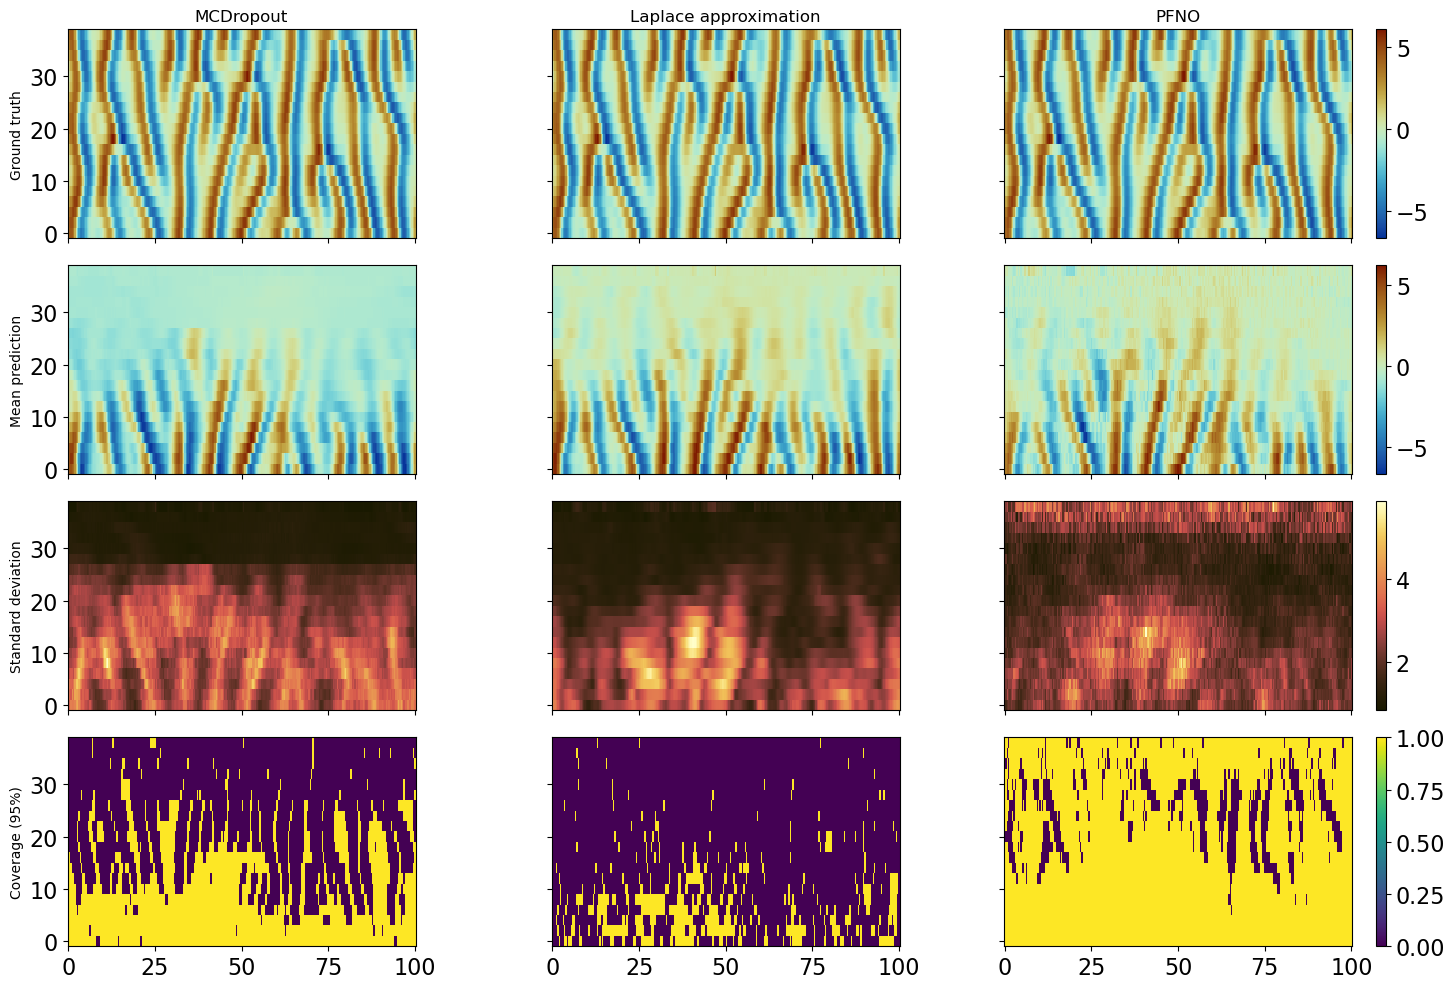

In [10]:
plot_predictions(u, preds, names, (x,y))

# Plot

In [11]:
idx = 0

a,u = test_data.__getitem__(samples[idx])
a = a.unsqueeze(0).numpy()
u = u.unsqueeze(0).numpy()

preds = [pred_dropout[idx],pred_la[idx], pred_pfno[idx]]
names = ['Dropout','LA', 'PFNO']

/tmp/ipykernel_19793/812412879.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = mpl.cm.get_cmap('viridis')


Dropout- Coverage: 0.386328125
LA- Coverage: 0.1232421875
PFNO- Coverage: 0.8697265625


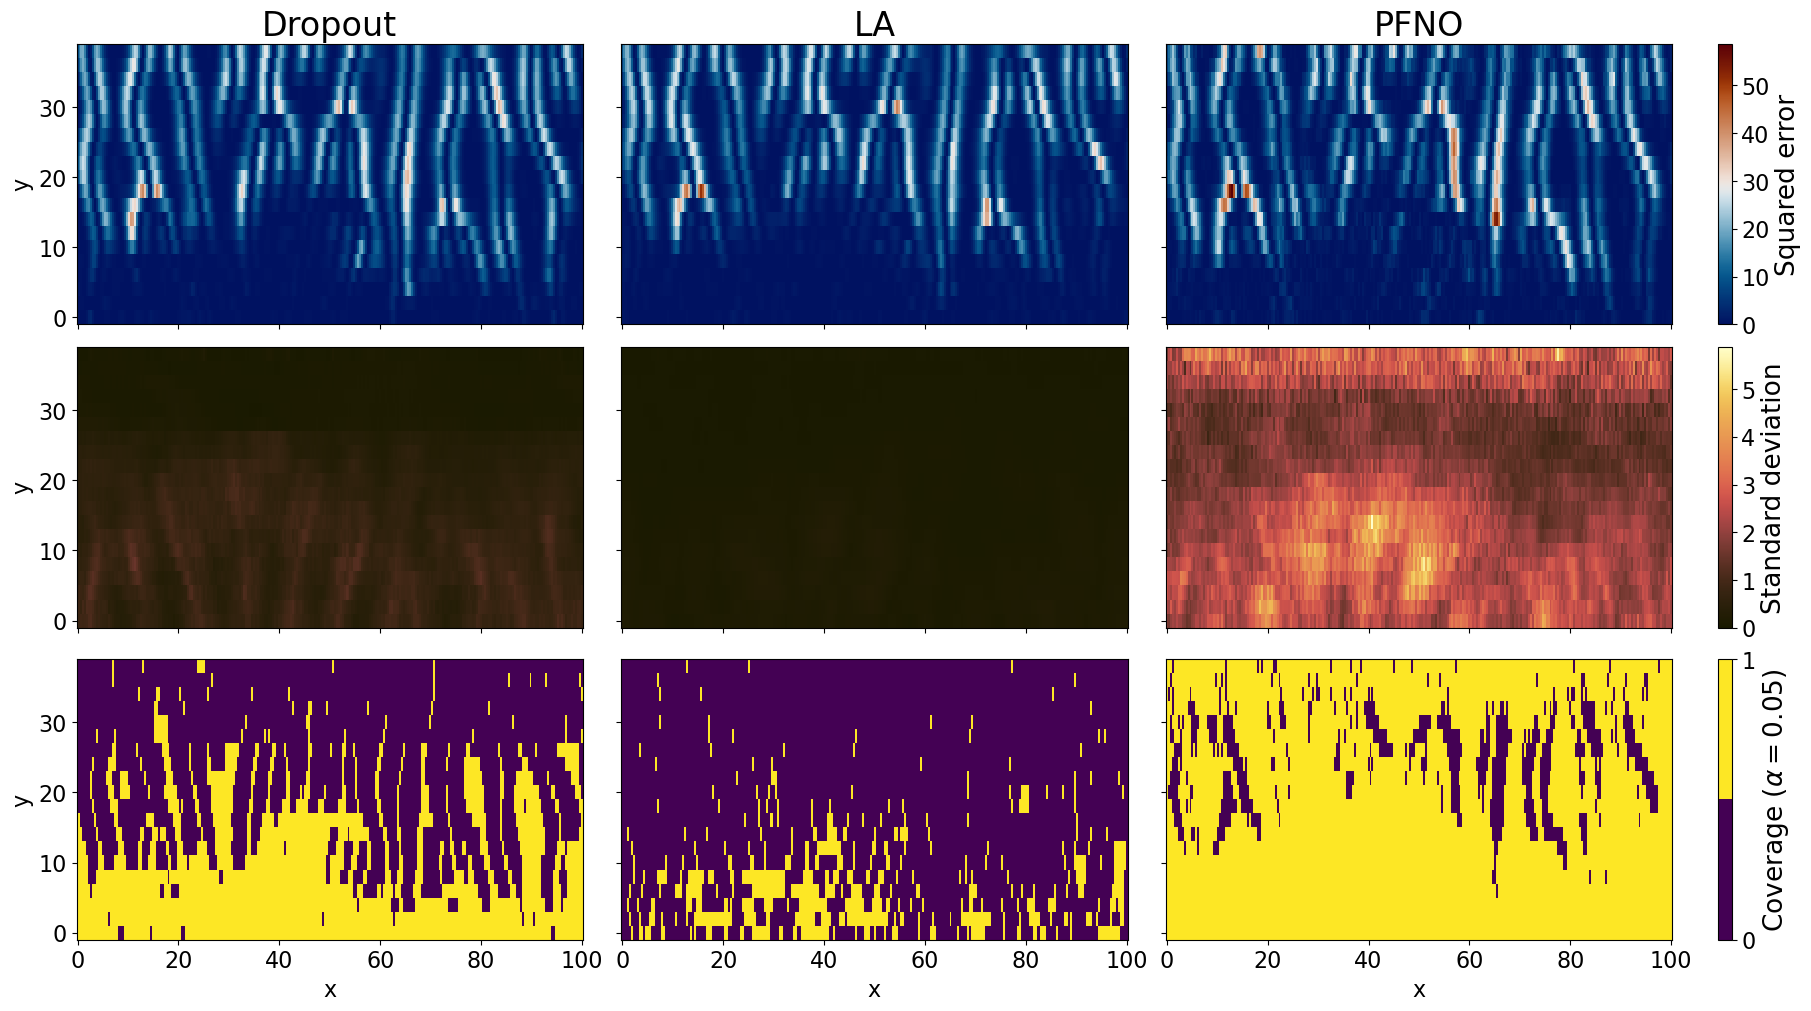

In [12]:
plot_statistics(u, preds, names, (x,y))

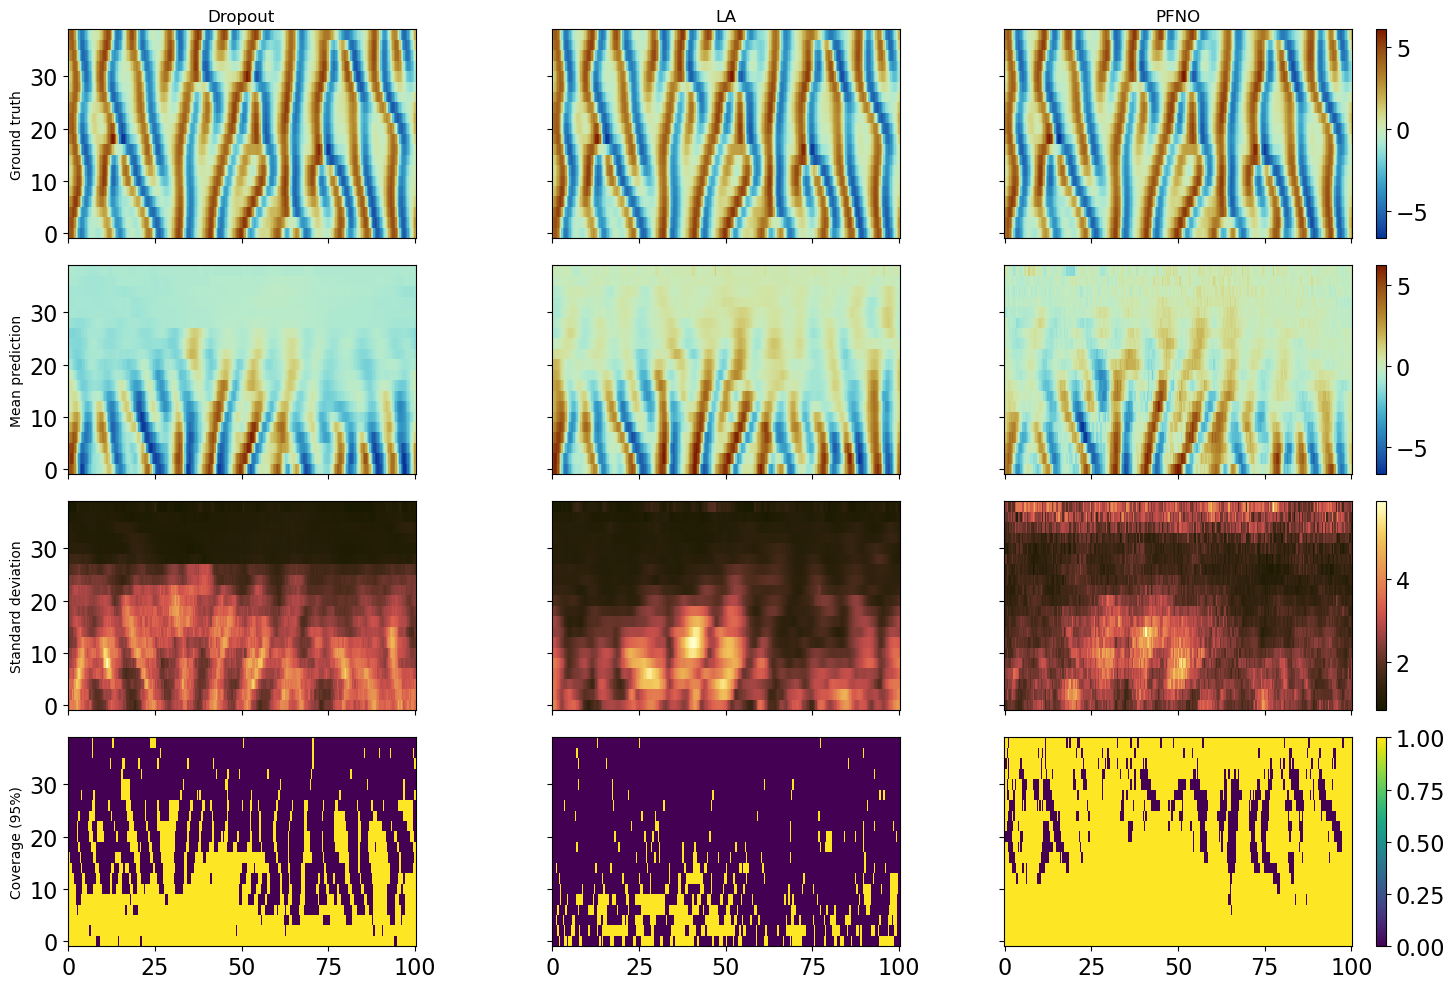

In [13]:
plot_predictions(u, preds, names, (x,y))